In [1]:
''' 
    Необходимо установить библиотеку SQLAlchemy, если она отсутствует в вашей среде. Смотрите документацию для вашей среды.
    Если вы используете PIP: pip install SQLAlchemy
    Если вы используете Anaconda: conda install -c anaconda sqlalchemy
    обращаться к БД можно с помощью pandas:

    sql = #ваш запрос на SQL в виде строки
    df = pd.read_sql(sql, engine)

    либо таким способом:
    with engine.begin() as conn:
        sql = #ваш запрос на SQL в виде строки
        conn.execute(sql)
'''

import pandas as pd
from sqlalchemy import create_engine
import numpy as np

## **ТЕСТОВОЕ ЗАДАНИЕ**

В настоящем задании вы получаете доступ к набору данных о стоимости недвижимости в различных районах штата Калифорния, США.

Данные хранятся в реляционной БД в виде двух таблиц:

1. **neighborhoods** - случайная выборка районов штата Калифорния. Каждая строка таблицы представляет собой какой-то район, имеющий такие атрибуты, как:

    - id - уникальный идентификатор, primary key;
    - longitude - географическая долгота, град.;
    - latitude - географическая широта, град.;
    - median_house_value - медианная стоимость жилого дома в данном районе, доллар США;
    - population - численность населения района, чел.;
    - ocean_proximity - кластер по принципу близости к океану, качественная переменная;



2. **cluster_mean_values** - каждая строка данной таблицы представляет собой кластер районов, сгруппированных по принципу близости к океану. Атрибуты:

    - ocean_proximity_cluster - кластер по принципу близости к океану, качественная переменная;
    - mean_median_house_value - среднее значение медианной стоимости жилого дома во ВСЕХ районах данного кластера, доллар США;

> **ОБРАТИТЕ ВНИМАНИЕ:** mean_median_house_value - значение для всей генеральной совокупности районов в кластере. Таблица neighborhoods, в свою очередь, содержит только ВЫБОРКИ из каждого кластера, но не ген. совокупности. Если вы посчитаете среднее арифметическое median_house_value - это будет ВЫБОРОЧНЫМ значением.

**ВАШИ ЗАДАЧИ:**

1) Извлечь таблицу neighborhoods в датафрейм. В части записей отсутствуют данные в атрибуте ocean_proximity (null-значения), их необходимо восстановить. Фактически, это задача классификации. Проведите разведочный анализ, подумайте, как в принципе её возможно решить;

2) Исправить null-значения ocean_proximity в самой БД. Условие: нельзя заменять таблицу в БД на новую, только через обновление значений с помощью SQL;

3) С помощью SQL создать объединенный датасет со значениями из двух таблиц БД, т.е. чтобы у каждого района было известно среднее арифметическое медианной стоимости жилья для районов в его кластере. Условие: только с помощью SQL, не с помощью Python;

4) Определить форму распределения median_house_value в каждом кластере. Определить выборочные средние median_house_value и их отклонения от средних ген. совокупностей. Все изобразить графически для каждого кластера. В виде комментария описать ваши выводы о репрезентативности выборок;

5) Определить зависимость стоимости жилья от численности населения района в каждом кластере. Описать в виде комментария;

> P.S. Каждое задание необходимо сопроводить комментариями, в которых вы поясняете, чего конкретно добиваетесь и почему используете именно выбранный способ решения. Обоснуйте ваши действия и сформулируйте выводы.

In [2]:
#установление соединения с БД
engine = create_engine('sqlite:///test_project.db')

## 1. Извлечём таблицу neighborhoods в датафрейм и восстановим данные в атрибуте ocean_proximity

In [3]:
# загрузим neighborhoods в df
sql = 'select * from neighborhoods n;'
df_neighborhoods = pd.read_sql(sql, engine)
df_neighborhoods

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,None
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY
3,3,-122.25,37.85,341300.0,558.0,None
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY
...,...,...,...,...,...,...
16208,16208,-121.09,39.48,78100.0,845.0,INLAND
16209,16209,-121.21,39.49,77100.0,356.0,INLAND
16210,16210,-121.22,39.43,92300.0,1007.0,INLAND
16211,16211,-121.32,39.43,84700.0,741.0,None


In [4]:
df_neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16213 entries, 0 to 16212
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  16213 non-null  int64  
 1   longitude           16213 non-null  float64
 2   latitude            16213 non-null  float64
 3   median_house_value  16213 non-null  float64
 4   population          16213 non-null  float64
 5   ocean_proximity     11200 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 760.1+ KB


Как и было обещано в задании, часть данных о принадлежности районов к кластерам по принипу близости к океану отсуствует.
Для прогнозирования данных о принадлежности районов к кластерам воспользуемся **линейной регрессией**.

In [66]:
# разделим df_neighborhoods на два df: df_neighborhoods_ocean_proximity, где ocean_proximity значим, и df_neighborhoods_no_ocean_proximity, где он None
df_neighborhoods_ocean_proximity = df_neighborhoods[df_neighborhoods['ocean_proximity'].notna()]
df_neighborhoods_no_ocean_proximity = df_neighborhoods[df_neighborhoods['ocean_proximity'].isna()]
# сохраним копию df_neighborhoods_no_ocean_proximity с категориальными значениями в ocean_proximity для некоторых дальнейших манипуляций 
df_neighborhoods_ploy = df_neighborhoods_ocean_proximity

In [6]:
# посмотрим, какие значения принимает атрибут ocean_proximity
df_neighborhoods_ocean_proximity_unique = df_neighborhoods.ocean_proximity.unique()
list(df_neighborhoods_ocean_proximity_unique[1:])

['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND']

Построим модель линейной регрессии, обучим её на данных о принадлежности районов к кластерам и применим модель для прогнозирования недостающих данных.

In [7]:
# заменим номинативные переменные числовыми для простроения модели линейной регрессии
df_neighborhoods_ocean_proximity = df_neighborhoods_ocean_proximity.replace({'ocean_proximity': {'NEAR BAY': 1, '<1H OCEAN': 2, 'INLAND': 3, 'NEAR OCEAN': 4, 'ISLAND': 5}})

In [8]:
df_neighborhoods_ocean_proximity.groupby('ocean_proximity').count()

,id,longitude,latitude,median_house_value,population
ocean_proximity,,,,,
1,1241,1241,1241,1241,1241
2,4967,4967,4967,4967,4967
3,3547,3547,3547,3547,3547
4,1443,1443,1443,1443,1443
5,2,2,2,2,2


In [9]:
# нормально, ничего не сломалось, данные качественные
df_neighborhoods_ocean_proximity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11200 entries, 1 to 16212
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11200 non-null  int64  
 1   longitude           11200 non-null  float64
 2   latitude            11200 non-null  float64
 3   median_house_value  11200 non-null  float64
 4   population          11200 non-null  float64
 5   ocean_proximity     11200 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 612.5 KB


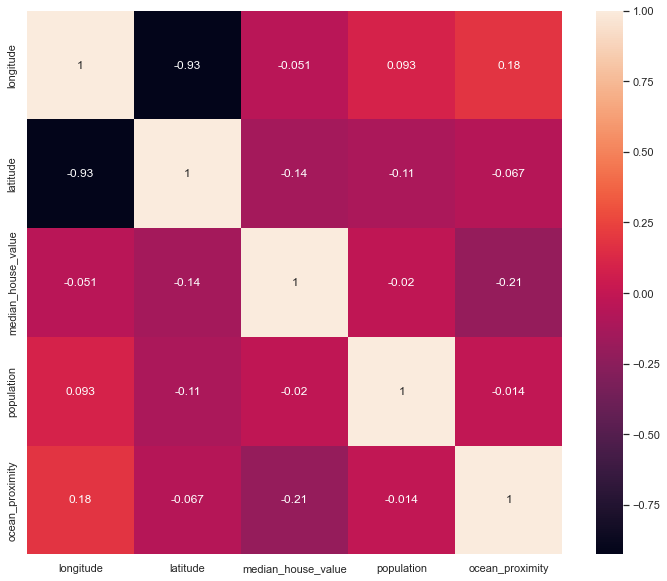

In [10]:
# проверим наличие линейной зависимости между атрибутами
import seaborn as sns
cols = ['longitude', 'latitude', 'median_house_value', 'population', 'ocean_proximity']
sns.set(rc = {'figure.figsize':(12,10)})
hm = sns.heatmap(df_neighborhoods_ocean_proximity[cols].corr(), annot=True)

Линейная корреляция между кластером и другими показателями (за исключением медианной стоимости дома, где коэффициент незначиельно выше) практически отсутствет, что, впрочем, и не удивительно.
Важно другое - отсутствие линейной взаимосвязи между потенциальными предикторами позволяет использовать для построения модели все имеющиеся данные без опасения возникновения 
[мультиколлинеарности](https://ru.wikipedia.org/wiki/Мультиколлинеарность#:~:text=Мультиколлинеарность%20(multicollinearity)%20—%20в%20эконометрике,наличие%20сильной%20корреляции%20между%20факторами) 
и проблемами сходимости модели. Из этого утверждения, конечно, нужно исключить географические координаты, выскокая корреляция между которыми обусловлена самой их природой, но будем надеяться, что на качество прогноза это не повлияет.

Text(0, 0.5, 'latitude')

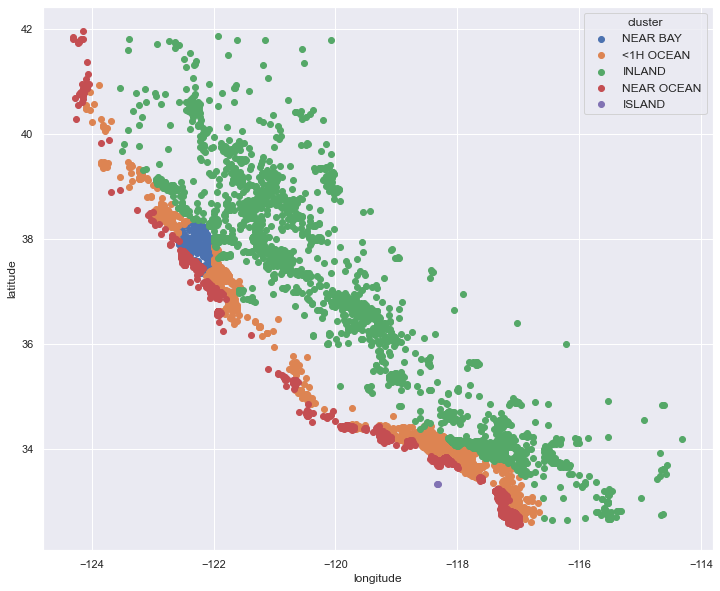

In [47]:
# посмотрим на расположение районов "на местности"
import matplotlib.pyplot as plt
for cluster in list(df_neighborhoods_ocean_proximity_unique[1:]):
    # выберем значения, соответствующие кластеру из списка
    subset = df_neighborhoods_ploy[df_neighborhoods_ploy.ocean_proximity == cluster]
    
    plt.scatter(subset.longitude, subset.latitude, label = cluster);
    plt.grid(True)
    
plt.legend(prop={'size': 12}, title = 'cluster')
plt.xlabel('longitude')
plt.ylabel('latitude')

In [68]:
df_neighborhoods_ploy

,id,longitude,latitude,median_house_value,population,ocean_proximity
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY
5,5,-122.25,37.85,269700.0,413.0,NEAR BAY
8,8,-122.26,37.84,226700.0,1206.0,NEAR BAY
...,...,...,...,...,...,...
16207,16207,-121.56,39.27,116800.0,1041.0,INLAND
16208,16208,-121.09,39.48,78100.0,845.0,INLAND
16209,16209,-121.21,39.49,77100.0,356.0,INLAND
16210,16210,-121.22,39.43,92300.0,1007.0,INLAND


In [70]:
df_neighborhoods_ploy[df_neighborhoods_ploy.ocean_proximity == 'NEAR BAY']

,id,longitude,latitude,median_house_value,population,ocean_proximity
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY
5,5,-122.25,37.85,269700.0,413.0,NEAR BAY
8,8,-122.26,37.84,226700.0,1206.0,NEAR BAY
...,...,...,...,...,...,...
15008,15008,-122.46,38.29,271700.0,686.0,NEAR BAY
15009,15009,-122.47,38.29,208000.0,1277.0,NEAR BAY
15010,15010,-122.45,38.27,262300.0,1994.0,NEAR BAY
15014,15014,-122.49,38.27,213200.0,1657.0,NEAR BAY


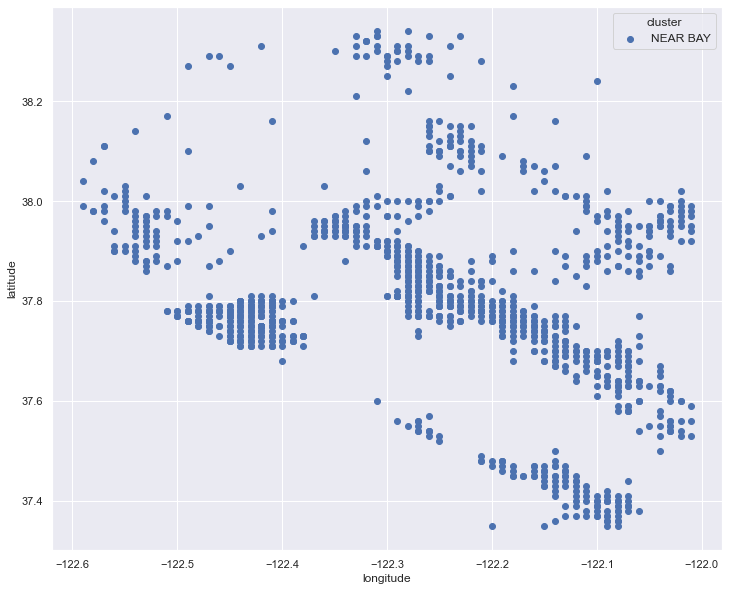

In [76]:
# посмотрим нехарактерный район NEAR BAY
subset = df_neighborhoods_ploy[df_neighborhoods_ploy.ocean_proximity == 'NEAR BAY']
    
plt.scatter(subset.longitude, subset.latitude, label = 'NEAR BAY')
plt.grid(True)
    
plt.legend(prop={'size': 12}, title = 'cluster')
plt.xlabel('longitude')
plt.ylabel('latitude');

Видно, что взаимное расположение районов соответствует границам штата Калифорния (удивительно, да?), но наличие сильной линейной корреляции между широтой и долготой
на качество прогноза не повлияет.

Кстати, один из возможных вариантов прогноза принадлежности района к кластеру - простое отнесение его к определённому диапазону (долгота, широта). Но мы продолжим с линейной регрессией.

А тут у нас карта плотности населения этой вашей Калифорнии. Население распределено неравномерно, и для нас это хорошо.

![](https://i.pinimg.com/originals/c0/b8/e4/c0b8e43c1385f97a523a91e1668a27c2.png)

#### Из всего сказанного следует, что в качестве предикторов при построении модели линейной регрессии мы вправе использовать все имеющиеся атрибуты за исключением совсем абстрактного id.

### Линейная регрессия

In [48]:
df_neighborhoods_ocean_proximity.groupby('ocean_proximity').count()

,id,longitude,latitude,median_house_value,population
ocean_proximity,,,,,
1,1241,1241,1241,1241,1241
2,4967,4967,4967,4967,4967
3,3547,3547,3547,3547,3547
4,1443,1443,1443,1443,1443
5,2,2,2,2,2


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
X, y = df_neighborhoods_ocean_proximity[['longitude', 'latitude', 'population', 'median_house_value']], df_neighborhoods_ocean_proximity['ocean_proximity']
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.2)
model_lr = LinearRegression()
model_lr.fit(X_train_lr, y_train_lr)

LinearRegression()

In [50]:
# оценим точность модели
from sklearn.metrics import mean_squared_error

In [51]:
mean_squared_error (y_train_lr, model_lr.predict(X_train_lr))

0.6516685966811027

In [52]:
mean_squared_error (y_test_lr, model_lr.predict(X_test_lr))

0.6423587862295387

Срение квадратические отклонения в контрольной и тестовой выборке практически равны. Модель хорошая, годная.

Применим же её.

### Предсказание

In [53]:
# возьмём известные данные
P = df_neighborhoods_no_ocean_proximity[['longitude', 'latitude', 'population', 'median_house_value']]

In [54]:
pd.options.mode.chained_assignment = None
# и рассчитаем неизвестные с использованием модели
df_neighborhoods_no_ocean_proximity['opp'] = model_lr.predict(P)
# округлим до приемлемого вида, очистим, присоединим к df_neighborhoods_no_ocean_proximity
df_neighborhoods_no_ocean_proximity['ocean_proximity_predict'] = round(df_neighborhoods_no_ocean_proximity.opp)
df_neighborhoods_no_ocean_proximity = df_neighborhoods_no_ocean_proximity.drop(['ocean_proximity', 'opp'], axis = 1).rename(columns = {'ocean_proximity_predict': 'ocean_proximity'})

In [55]:
df_neighborhoods_no_ocean_proximity

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,2.0
3,3,-122.25,37.85,341300.0,558.0,2.0
6,6,-122.25,37.84,299200.0,1094.0,2.0
7,7,-122.25,37.84,241400.0,1157.0,2.0
9,9,-122.25,37.84,261100.0,1551.0,2.0
...,...,...,...,...,...,...
16196,16196,-121.48,39.05,100000.0,151.0,3.0
16201,16201,-121.52,39.12,72000.0,29.0,3.0
16203,16203,-121.32,39.13,162500.0,169.0,3.0
16204,16204,-121.48,39.10,92400.0,1018.0,3.0


In [56]:
df_neighborhoods_no_ocean_proximity.groupby('ocean_proximity').count()

,id,longitude,latitude,median_house_value,population
ocean_proximity,,,,,
2.0,2413,2413,2413,2413,2413
3.0,2589,2589,2589,2589,2589
4.0,11,11,11,11,11


In [57]:
# соединим разделённые ранее таблицы обратно
df_neighborhoods_full = pd.concat([df_neighborhoods_ocean_proximity, df_neighborhoods_no_ocean_proximity])
df_neighborhoods_full

,id,longitude,latitude,median_house_value,population,ocean_proximity
1,1,-122.22,37.86,358500.0,2401.0,1.0
2,2,-122.24,37.85,352100.0,496.0,1.0
4,4,-122.25,37.85,342200.0,565.0,1.0
5,5,-122.25,37.85,269700.0,413.0,1.0
8,8,-122.26,37.84,226700.0,1206.0,1.0
...,...,...,...,...,...,...
16196,16196,-121.48,39.05,100000.0,151.0,3.0
16201,16201,-121.52,39.12,72000.0,29.0,3.0
16203,16203,-121.32,39.13,162500.0,169.0,3.0
16204,16204,-121.48,39.10,92400.0,1018.0,3.0


In [58]:
df_neighborhoods_full.groupby('ocean_proximity').count()

,id,longitude,latitude,median_house_value,population
ocean_proximity,,,,,
1.0,1241,1241,1241,1241,1241
2.0,7380,7380,7380,7380,7380
3.0,6136,6136,6136,6136,6136
4.0,1454,1454,1454,1454,1454
5.0,2,2,2,2,2


In [59]:
# возвратим кластерам их исторические имена
df_neighborhoods_full = df_neighborhoods_full.replace({'ocean_proximity': {1: 'NEAR BAY', 2: '<1H OCEAN', 3: 'INLAND', 4: 'NEAR OCEAN', 5: 'ISLAND'}})
df_neighborhoods_full = df_neighborhoods_full.sort_values('id')

In [60]:
# готово!
df_neighborhoods_full.head()

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,<1H OCEAN
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY
3,3,-122.25,37.85,341300.0,558.0,<1H OCEAN
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY


Посмотрим на новую и прежнюю таблицы. У них всё хорошо:

In [61]:
df_neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16213 entries, 0 to 16212
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  16213 non-null  int64  
 1   longitude           16213 non-null  float64
 2   latitude            16213 non-null  float64
 3   median_house_value  16213 non-null  float64
 4   population          16213 non-null  float64
 5   ocean_proximity     11200 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 760.1+ KB


In [62]:
df_neighborhoods_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16213 entries, 0 to 16212
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  16213 non-null  int64  
 1   longitude           16213 non-null  float64
 2   latitude            16213 non-null  float64
 3   median_house_value  16213 non-null  float64
 4   population          16213 non-null  float64
 5   ocean_proximity     16213 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 886.6+ KB


Text(0, 0.5, 'latitude')

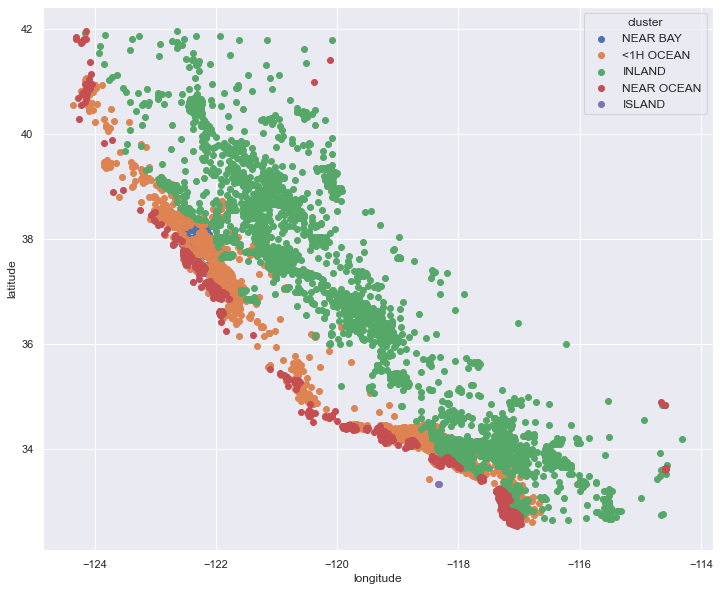

In [63]:
# сравним расположение районов "на местности"
cluster_list = ['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND']
for cluster in cluster_list:
    # выберем значения, соответствующие кластеру из списка
    subset = df_neighborhoods_full[df_neighborhoods_full.ocean_proximity == cluster]
    
    plt.scatter(subset.longitude, subset.latitude, label = cluster);
    plt.grid(True)
    
plt.legend(prop={'size': 12}, title = 'cluster')
plt.xlabel('longitude')
plt.ylabel('latitude')

***

### Mетод сравнений (для размышлений)

Выше упоминалось про отнесение района к кластеру на основании сравнения широты и долготы. Сравним с ближайшими имеющимися значениями и посмотрим, что получится.

In [25]:
# итак, вот исходный df
df_neighborhoods

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,None
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY
3,3,-122.25,37.85,341300.0,558.0,None
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY
...,...,...,...,...,...,...
16208,16208,-121.09,39.48,78100.0,845.0,INLAND
16209,16209,-121.21,39.49,77100.0,356.0,INLAND
16210,16210,-121.22,39.43,92300.0,1007.0,INLAND
16211,16211,-121.32,39.43,84700.0,741.0,None


Отсортируем исходные данные по возрастанию долготы и широты (раздельно):

In [26]:
# долгота
df_longitude = df_neighborhoods[['id', 'longitude', 'ocean_proximity']].sort_values('longitude').reset_index()
df_longitude = df_longitude.drop('index', axis = 1)
df_longitude.head()

,id,longitude,ocean_proximity
0,2087,-124.35,None
1,1447,-124.30,NEAR OCEAN
2,1454,-124.30,NEAR OCEAN
3,2070,-124.27,NEAR OCEAN
4,2088,-124.25,NEAR OCEAN


In [27]:
# широта
df_latitude = df_neighborhoods[['id', 'latitude', 'ocean_proximity']].sort_values('latitude').reset_index()
df_latitude = df_latitude.drop('index', axis = 1)
df_latitude.head()

,id,latitude,ocean_proximity
0,11619,32.54,NEAR OCEAN
1,11635,32.55,NEAR OCEAN
2,11625,32.56,NEAR OCEAN
3,11615,32.56,NEAR OCEAN
4,11618,32.56,NEAR OCEAN


In [28]:
def cluster_forecast (df_longitude, df_latitude):
    '''
    функция эта принимает списки широты и долготы районов,
    устанавливает название кластера 'border' в первой и последней строке, если исходно название кластера
    там пустое. Затем для всех пустых значений долготы в атрибуте ocean_proximity сравнивается значение "до" и "после",
    и если эти значения равны, такое же значение присваивается пустой ячейке. Те же действия повторяются для широты.
    '''
    df_longitude = df_longitude.sort_values('longitude')
    df_latitude = df_latitude.sort_values('latitude')
    if pd.isnull(df_longitude.ocean_proximity.iloc[0]): df_longitude.ocean_proximity.iloc[0] = 'border'
    if pd.isnull(df_longitude.ocean_proximity.iloc[-1]): df_longitude.ocean_proximity.iloc[-1] = 'border'
    if pd.isnull(df_latitude.ocean_proximity.iloc[0]): df_latitude.ocean_proximity.iloc[0] = 'border'
    if pd.isnull(df_latitude.ocean_proximity.iloc[-1]): df_latitude.ocean_proximity.iloc[-1] = 'border'
    for i in range(1, len(df_longitude) - 1):
        if pd.isnull(df_longitude.ocean_proximity.iloc[i]) and df_longitude.ocean_proximity.iloc[i - 1] == df_longitude.ocean_proximity.iloc[i + 1]:
            df_longitude.ocean_proximity.iloc[i] = df_longitude.ocean_proximity.iloc[i - 1]
        if pd.isnull(df_latitude.ocean_proximity.iloc[i]) and df_latitude.ocean_proximity.iloc[i - 1] == df_latitude.ocean_proximity.iloc[i + 1]:
            df_latitude.ocean_proximity.iloc[i] = df_latitude.ocean_proximity.iloc[i - 1]
    df_clusters = pd.merge(df_longitude, df_latitude, on = 'id')
    df_clusters = df_clusters.sort_values('id').reset_index()
    df_clusters = df_clusters.replace('border', pd.isnull).drop('index', axis = 1)
    return df_clusters

In [29]:
df_clusters = cluster_forecast (df_longitude, df_latitude)

Получаем df_clusters, в котором в атрибуте ocean_proximity_x хранятся имеющиеся данные о кластере + прогноз на основнии сравнения долготы,
в атрибуте ocean_proximity_y, соответственно, имеющиеся данные о кластере + прогноз на основнии сравнения широты.

In [30]:
df_clusters = df_clusters.replace(np.nan, '', regex=True)
df_clusters

,id,longitude,ocean_proximity_x,latitude,ocean_proximity_y
0,0,-122.23,,37.88,
1,1,-122.22,NEAR BAY,37.86,NEAR BAY
2,2,-122.24,NEAR BAY,37.85,NEAR BAY
3,3,-122.25,,37.85,NEAR BAY
4,4,-122.25,NEAR BAY,37.85,NEAR BAY
...,...,...,...,...,...
16208,16208,-121.09,INLAND,39.48,INLAND
16209,16209,-121.21,INLAND,39.49,INLAND
16210,16210,-121.22,INLAND,39.43,INLAND
16211,16211,-121.32,,39.43,INLAND


Окончательное значение атрибуту кластера присвоим так: если ocean_proximity_x и ocean_proximity_y совпадают - их значение; если одно из них пустое - значение второго;
если значения не совпадают или оба пустые - пустое значение.

In [31]:
df_clusters['cluster'] = ''
for i in range(0, len(df_clusters)):
    if df_clusters.ocean_proximity_x.iloc[i] == df_clusters.ocean_proximity_y.iloc[i]:
        df_clusters.cluster.iloc[i] = df_clusters.ocean_proximity_y.iloc[i]
    elif df_clusters.ocean_proximity_x.iloc[i] == '' and df_clusters.ocean_proximity_y.iloc[i] != '':
        df_clusters.cluster.iloc[i] = df_clusters.ocean_proximity_y.iloc[i]
    elif df_clusters.ocean_proximity_x.iloc[i] != '' and df_clusters.ocean_proximity_y.iloc[i] == '':
        df_clusters.cluster.iloc[i] = df_clusters.ocean_proximity_x.iloc[i]
    else:
        df_clusters.cluster.iloc[i] = ''
df_clusters = df_clusters[['id', 'cluster']]

In [32]:
df_clusters.head()

,id,cluster
0,0,
1,1,NEAR BAY
2,2,NEAR BAY
3,3,NEAR BAY
4,4,NEAR BAY


In [33]:
# присоединим полученный "прогноз" к исходному df
df_neighborhoods_more_full = pd.merge(df_neighborhoods, df_clusters, on = 'id')
df_neighborhoods_more_full = df_neighborhoods_more_full.replace('', np.nan, regex=True)
df_neighborhoods_more_full

,id,longitude,latitude,median_house_value,population,ocean_proximity,cluster
0,0,-122.23,37.88,452600.0,322.0,None,NaN
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY,NEAR BAY
3,3,-122.25,37.85,341300.0,558.0,None,NEAR BAY
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY,NEAR BAY
...,...,...,...,...,...,...,...
16208,16208,-121.09,39.48,78100.0,845.0,INLAND,INLAND
16209,16209,-121.21,39.49,77100.0,356.0,INLAND,INLAND
16210,16210,-121.22,39.43,92300.0,1007.0,INLAND,INLAND
16211,16211,-121.32,39.43,84700.0,741.0,None,INLAND


In [34]:
# посмотрим
df_neighborhoods_more_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16213 entries, 0 to 16212
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  16213 non-null  int64  
 1   longitude           16213 non-null  float64
 2   latitude            16213 non-null  float64
 3   median_house_value  16213 non-null  float64
 4   population          16213 non-null  float64
 5   ocean_proximity     11200 non-null  object 
 6   cluster             13837 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1013.3+ KB


2637 пустых значений удалось исправить, но ещё 2826 осталось: прогноз не срабатывает в случае нескольких пустых ячеек подряд. Конечно, можно поробовать запустить процедуру ещё раз
(или несколько раз), а тем, что останется, пренебречь.

Но не нравится мне этот способ. Уж лучше линейная регрессия.

***

## 2. Исправим значения ocean_proximity в базе данных

In [35]:
df_neighborhoods_full = df_neighborhoods_full.reset_index()

In [36]:
# создадим копию базы данных test_project_new.db, чтобы ранее написанный код мог работать с иходной базой, и подключимся к новой копии
engine = create_engine('sqlite:///test_project_new.db')
# заливаем в базу test_project_new.db новые данные
for index, row in df_neighborhoods_full.iterrows():
    with engine.begin() as conn:
        sql = "Update neighborhoods set ocean_proximity = '" + str(row['ocean_proximity']) + "' where id = " + str(row['id'])
        conn.execute(sql)

In [37]:
# посмотрим, что получилось
sql = 'select * from neighborhoods n;'
df_neighborhoods_new = pd.read_sql(sql, engine)
df_neighborhoods_new

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,<1H OCEAN
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY
3,3,-122.25,37.85,341300.0,558.0,<1H OCEAN
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY
...,...,...,...,...,...,...
16208,16208,-121.09,39.48,78100.0,845.0,INLAND
16209,16209,-121.21,39.49,77100.0,356.0,INLAND
16210,16210,-121.22,39.43,92300.0,1007.0,INLAND
16211,16211,-121.32,39.43,84700.0,741.0,INLAND


Сравним таблицы:

In [38]:
df_neighborhoods_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16213 entries, 0 to 16212
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  16213 non-null  int64  
 1   longitude           16213 non-null  float64
 2   latitude            16213 non-null  float64
 3   median_house_value  16213 non-null  float64
 4   population          16213 non-null  float64
 5   ocean_proximity     16213 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 760.1+ KB


In [39]:
df_neighborhoods_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16213 entries, 0 to 16212
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               16213 non-null  int64  
 1   id                  16213 non-null  int64  
 2   longitude           16213 non-null  float64
 3   latitude            16213 non-null  float64
 4   median_house_value  16213 non-null  float64
 5   population          16213 non-null  float64
 6   ocean_proximity     16213 non-null  object 
dtypes: float64(4), int64(2), object(1)
memory usage: 886.8+ KB


In [40]:
df_neighborhoods_new.describe(include = 'all')

,id,longitude,latitude,median_house_value,population,ocean_proximity
count,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000,16213
unique,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,7544
mean,8106.000000,-119.563455,35.624790,207457.124591,1430.090236,NaN
std,4680.434293,2.001636,2.131828,115450.627025,1156.503275,NaN
min,0.000000,-124.350000,32.540000,14999.000000,3.000000,NaN
25%,4053.000000,-121.790000,33.930000,120400.000000,786.000000,NaN
50%,8106.000000,-118.480000,34.250000,180000.000000,1165.000000,NaN
75%,12159.000000,-118.010000,37.710000,265700.000000,1727.000000,NaN


In [41]:
df_neighborhoods_full.describe(include = 'all')

,index,id,longitude,latitude,median_house_value,population,ocean_proximity
count,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000,16213.000000,16213
unique,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,NaN,7544
mean,8106.000000,8106.000000,-119.563455,35.624790,207457.124591,1430.090236,NaN
std,4680.434293,4680.434293,2.001636,2.131828,115450.627025,1156.503275,NaN
min,0.000000,0.000000,-124.350000,32.540000,14999.000000,3.000000,NaN
25%,4053.000000,4053.000000,-121.790000,33.930000,120400.000000,786.000000,NaN
50%,8106.000000,8106.000000,-118.480000,34.250000,180000.000000,1165.000000,NaN
75%,12159.000000,12159.000000,-118.010000,37.710000,265700.000000,1727.000000,NaN


### Profit!
***

### 3. С помощью только SQL создадим объединенный датасет со значениями из двух таблиц

In [42]:
# посомтрим, что такое cluster_mean_values
sql = 'select * from cluster_mean_values cmv;'
cluster_mean_values = pd.read_sql(sql, engine)
cluster_mean_values

,ocean_proximity_cluster,mean_median_house_value
0,<1H OCEAN,240084.29
1,INLAND,124805.39
2,ISLAND,380440.00
3,NEAR BAY,259212.31
4,NEAR OCEAN,249433.98


In [43]:
# соединим таблицы. Известно, что пропусков в атрибутах, по которым производим соединение, нет, значит о виде join'а можно не беспокоиться
# работать продолжаем с "исправленной" таблицей из базы test_project_new.db
sql = 'select * from neighborhoods n join cluster_mean_values cvm on n.ocean_proximity = cvm.ocean_proximity_cluster;'
df_neighborhoods_cluster = pd.read_sql(sql, engine)
df_neighborhoods_cluster

,id,longitude,latitude,median_house_value,population,ocean_proximity,ocean_proximity_cluster,mean_median_house_value
0,0,-122.23,37.88,452600.0,322.0,<1H OCEAN,<1H OCEAN,240084.29
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY,NEAR BAY,259212.31
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY,NEAR BAY,259212.31
3,3,-122.25,37.85,341300.0,558.0,<1H OCEAN,<1H OCEAN,240084.29
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY,NEAR BAY,259212.31
...,...,...,...,...,...,...,...,...
16208,16208,-121.09,39.48,78100.0,845.0,INLAND,INLAND,124805.39
16209,16209,-121.21,39.49,77100.0,356.0,INLAND,INLAND,124805.39
16210,16210,-121.22,39.43,92300.0,1007.0,INLAND,INLAND,124805.39
16211,16211,-121.32,39.43,84700.0,741.0,INLAND,INLAND,124805.39


In [44]:
df_neighborhoods_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16213 entries, 0 to 16212
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       16213 non-null  int64  
 1   longitude                16213 non-null  float64
 2   latitude                 16213 non-null  float64
 3   median_house_value       16213 non-null  float64
 4   population               16213 non-null  float64
 5   ocean_proximity          16213 non-null  object 
 6   ocean_proximity_cluster  16213 non-null  object 
 7   mean_median_house_value  16213 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1013.4+ KB


***

### 4. Определим форму распределения median_house_value в каждом кластере.

In [45]:
# назавния кластеров
df_neighborhoods_cluster_columns = df_neighborhoods_cluster.ocean_proximity_cluster.unique()
list(df_neighborhoods_cluster_columns)

['<1H OCEAN', 'NEAR BAY', 'INLAND', 'NEAR OCEAN', 'ISLAND']

Text(0, 0.5, 'density')

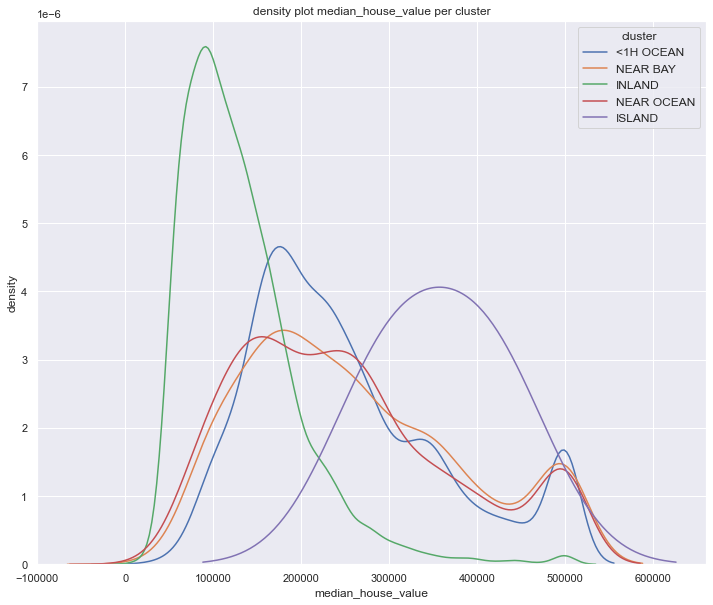

In [46]:
# импортируем потребные библиотеки
import seaborn as sns
import matplotlib.pyplot as plt
for cluster in list(df_neighborhoods_cluster_columns):
    # выберем значения, соответствующие кластеру из списка
    subset = df_neighborhoods_cluster[df_neighborhoods_cluster.ocean_proximity_cluster == cluster].median_house_value
        
    # построим график плотности распределения
    sns.kdeplot (subset, label = cluster)
    
# отформатируем график
plt.legend(prop={'size': 12}, title = 'cluster')
plt.title('density plot median_house_value per cluster')
plt.xlabel('median_house_value')
plt.ylabel('density')

Видно, что вдали от побережья распределение плотности вероятности медианной стоимости жилого дома в районе подчиняется **закону Пуассона**, но чем ближе к морю, тем хуже.
Картину пуассоновского распределения порят дорогие виллы и прочие особняки.

На этом фоне яркой звездой **нормального распределения** отчего-то вдруг сияет кластер ISLAND. Как так-то?

In [47]:
# посмотрим...
df_neighborhoods_cluster[df_neighborhoods_cluster.ocean_proximity_cluster == 'ISLAND']

,id,longitude,latitude,median_house_value,population,ocean_proximity,ocean_proximity_cluster,mean_median_house_value
6552,6552,-118.33,33.34,414700.0,1100.0,ISLAND,ISLAND,380440.0
6553,6553,-118.32,33.33,300000.0,733.0,ISLAND,ISLAND,380440.0


**Понятно - там всего два района. Кластер этот исключать из данных не станем, но все дальнейшие выводы применяем к нему с сугубой осторожностью.**

***

#### 4.1.Определим выборочные средние median_house_value и их отклонения от средних ген. совокупностей.

In [48]:
df_neighborhoods_cluster_group = df_neighborhoods_cluster.groupby('ocean_proximity_cluster').mean()[['median_house_value', 'mean_median_house_value']]
df_neighborhoods_cluster_group = df_neighborhoods_cluster_group.rename(columns = {'median_house_value': 'sample_average', 'mean_median_house_value': 'general_average'})
df_neighborhoods_cluster_group['deviation'] = df_neighborhoods_cluster_group.sample_average / df_neighborhoods_cluster_group.general_average
df_neighborhoods_cluster_group = df_neighborhoods_cluster_group.reset_index()
df_neighborhoods_cluster_group['representativeness'] = np.where(abs(df_neighborhoods_cluster_group.deviation - 1) <= 0.05, True, False)
df_neighborhoods_cluster_group

,ocean_proximity_cluster,sample_average,general_average,deviation,representativeness
0,<1H OCEAN,251528.025716,240084.29,1.047665,True
1,INLAND,130757.554588,124805.39,1.047692,True
2,ISLAND,357350.000000,380440.00,0.939307,False
3,NEAR BAY,259141.102337,259212.31,0.999725,True
4,NEAR OCEAN,249506.197387,249433.98,1.000290,True


Принято считать, что выборка репрезентативна, если выборочное среднее не отличается от генерального среднего более чем на 5 %. Исходя из этих соображений, выводы о репрезентативности 
выборок отражены в столбце representativeness.

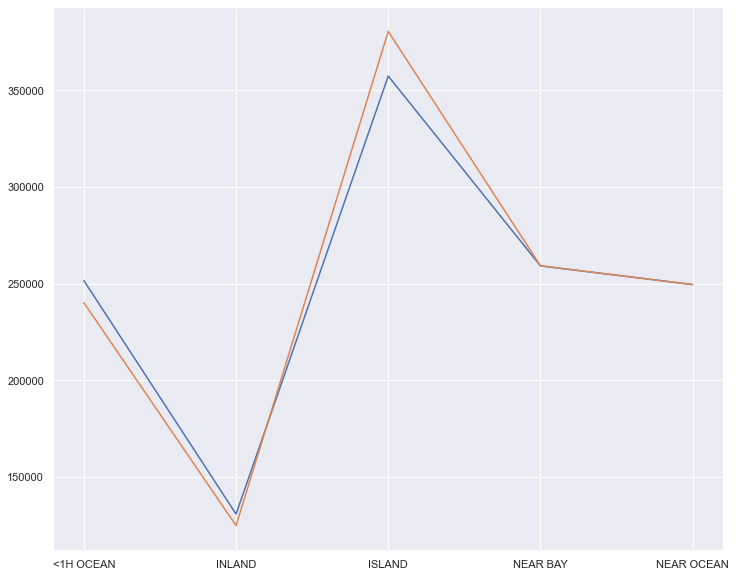

In [49]:
# выборочные и генеральные средние по кластерам
plt.plot(df_neighborhoods_cluster_group.ocean_proximity_cluster, df_neighborhoods_cluster_group.sample_average);
plt.grid(True)
plt.plot(df_neighborhoods_cluster_group.ocean_proximity_cluster, df_neighborhoods_cluster_group.general_average);
plt.grid(True)

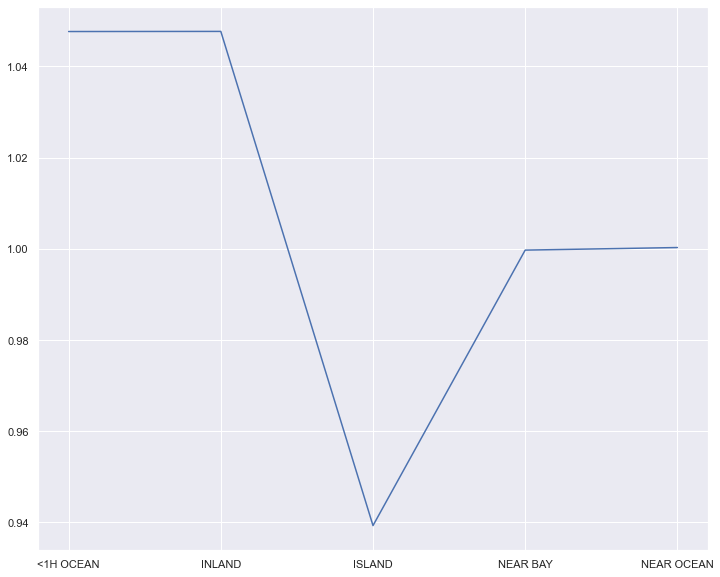

In [50]:
# отклонение выборочных и генеральных средних по кластерам
plt.plot(df_neighborhoods_cluster_group.ocean_proximity_cluster, df_neighborhoods_cluster_group.deviation);
plt.grid(True)

***

### 5. Определить зависимость стоимости жилья от численности населения района в каждом кластере. Описать в виде комментария

In [51]:
# рассчитаем значения коэффициентов линейной корреляции между медианной стоимстью дома и численностью населения района
corr_list = []
for cluster in list(df_neighborhoods_cluster_columns):
    corr = df_neighborhoods_cluster[df_neighborhoods_cluster.ocean_proximity_cluster == cluster].\
    median_house_value.corr(df_neighborhoods_cluster[df_neighborhoods_cluster.ocean_proximity_cluster == cluster].population)
    corr_list.append([cluster, round(corr, 2)])
df_corr_list = pd.DataFrame(corr_list, columns = ['cluster', 'correlation'])
df_corr_list

,cluster,correlation
0,<1H OCEAN,-0.08
1,NEAR BAY,0.01
2,INLAND,0.05
3,NEAR OCEAN,-0.05
4,ISLAND,1.00


Даже без учёта объёмов выборки видно, что линейной взаимосвязи нет. Видимо, причиной тому распространённость инстирута аредны жилья, благодаря котрой для жизни в 
хорошем районе приобретать там дом соврешенно не обязательно.

Кластер ISLAND продолжает сиять своей звездой, но мы ему больше не верим, так ведь?

Сделанный вывод подтверждается и изучением графика зависимости медианной стоимости жилья от численности наседения. Весёлых красок болтовня, горизонтально вытянутые скопления точек,
хаотичные выбросы и локальный рост в сверхдорогом сегменте.

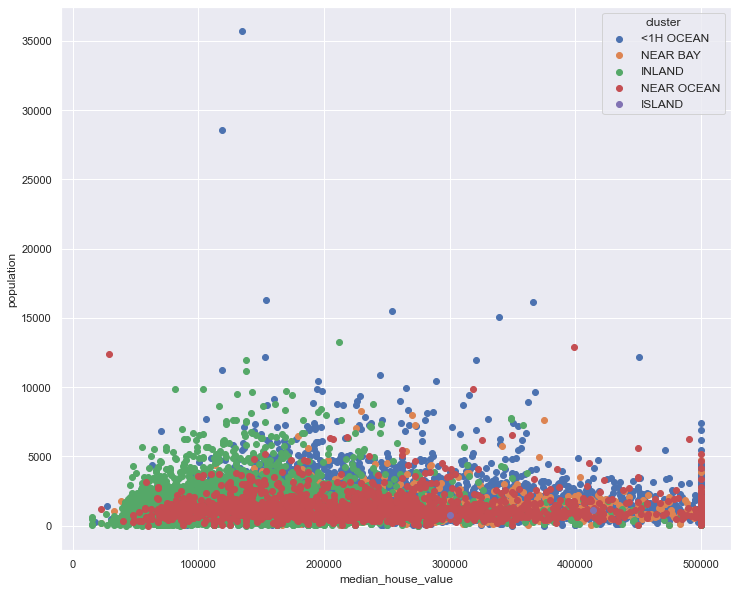

In [52]:
for cluster in list(df_neighborhoods_cluster_columns):
    # выберем значения, соответствующие кластеру из списка
    subset = df_neighborhoods_cluster[df_neighborhoods_cluster.ocean_proximity_cluster == cluster]
    
    plt.scatter(subset.median_house_value, subset.population, label = cluster)
    plt.grid(True)
    
plt.legend(prop={'size': 12}, title = 'cluster')
plt.xlabel('median_house_value')
plt.ylabel('population');

### Спасибо, что дочитали до конца!

***
***
***

# Добровольное упражнение в безумии на основе модели логистической регрессии

In [167]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np

In [ ]:
#установление соединения с БД
engine = create_engine('sqlite:///test_project.db')

[Логистическая регрессия или логит-модель](https://ru.wikipedia.org/wiki/Логистическая_регрессия) (англ. logit model) — статистическая модель, используемая для прогнозирования вероятности возникновения некоторого события путём его сравнения с логистической кривой. Эта регрессия выдаёт ответ в виде вероятности бинарного события (1 или 0).

Для каждого крастера на известных данных обучим модель логистической регрессии (принадлежит - не принадлежит) и применим получившиеся модели к неизвестным данным. Результаты сравним. 

In [160]:
# исходные данные
df_neighborhoods

,id,longitude,latitude,median_house_value,population,ocean_proximity
0,0,-122.23,37.88,452600.0,322.0,None
1,1,-122.22,37.86,358500.0,2401.0,NEAR BAY
2,2,-122.24,37.85,352100.0,496.0,NEAR BAY
3,3,-122.25,37.85,341300.0,558.0,None
4,4,-122.25,37.85,342200.0,565.0,NEAR BAY
...,...,...,...,...,...,...
16208,16208,-121.09,39.48,78100.0,845.0,INLAND
16209,16209,-121.21,39.49,77100.0,356.0,INLAND
16210,16210,-121.22,39.43,92300.0,1007.0,INLAND
16211,16211,-121.32,39.43,84700.0,741.0,None


In [161]:
from sklearn.linear_model import LogisticRegression # импортируем модуль логистической регрессии
# разделим df_neighborhoods на два df: df_neighborhoods_ocean_proximity, где ocean_proximity значим, и df_neighborhoods_no_ocean_proximity, где он None
df_neighborhoods_ocean_proximity = df_neighborhoods[df_neighborhoods['ocean_proximity'].notna()]
df_neighborhoods_no_ocean_proximity = df_neighborhoods[df_neighborhoods['ocean_proximity'].isna()]
# сформируем список кластеров для построения моделей
clusters_list = ['<1H_OCEAN', 'INLAND', 'ISLAND', 'NEAR_BAY', 'NEAR_OCEAN']
# для каждого кластера:
for cluster in clusters_list:
    # построим и обучи модель логистической регрессии
    X, y = df_clusters[['longitude', 'latitude', 'median_house_value', 'population']], df_clusters[cluster]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = LogisticRegression()
    model.fit(X_train, y_train)
    # возьмём известные данные с неизвестными кластерами
    log_reg = df_neighborhoods_no_ocean_proximity[['longitude', 'latitude', 'median_house_value', 'population']]
    # и построим прогноз принадлежности района к кластеру с использованием модели
    df_neighborhoods_no_ocean_proximity['opp'] = model.predict(log_reg)
    # округлим до приемлемого вида, очистим, присоединим к df_neighborhoods_no_ocean_proximity
    df_neighborhoods_no_ocean_proximity['ocean_proximity_predict'] = round(df_neighborhoods_no_ocean_proximity.opp)
    df_neighborhoods_no_ocean_proximity = df_neighborhoods_no_ocean_proximity.drop(['opp'], axis = 1).rename(columns = {'ocean_proximity_predict': cluster})
# очистим итоговый dataframe от мусорных столбцов
df_predict_clusters = df_neighborhoods_no_ocean_proximity.drop(['ocean_proximity'], axis = 1)

In [162]:
df_predict_clusters # данные о районах с неизвестным кластером + прогноз принадлежности к кластеру на основании логистической регрессии

,id,longitude,latitude,median_house_value,population,<1H_OCEAN,INLAND,ISLAND,NEAR_BAY,NEAR_OCEAN
0,0,-122.23,37.88,452600.0,322.0,0,0,0,1,0
3,3,-122.25,37.85,341300.0,558.0,0,0,0,0,0
6,6,-122.25,37.84,299200.0,1094.0,0,0,0,0,0
7,7,-122.25,37.84,241400.0,1157.0,0,0,0,0,0
9,9,-122.25,37.84,261100.0,1551.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
16196,16196,-121.48,39.05,100000.0,151.0,0,1,0,0,0
16201,16201,-121.52,39.12,72000.0,29.0,0,1,0,0,0
16203,16203,-121.32,39.13,162500.0,169.0,0,0,0,0,0
16204,16204,-121.48,39.10,92400.0,1018.0,0,1,0,0,0


In [163]:
df_predict_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5013 entries, 0 to 16211
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5013 non-null   int64  
 1   longitude           5013 non-null   float64
 2   latitude            5013 non-null   float64
 3   median_house_value  5013 non-null   float64
 4   population          5013 non-null   float64
 5   <1H_OCEAN           5013 non-null   uint8  
 6   INLAND              5013 non-null   uint8  
 7   ISLAND              5013 non-null   uint8  
 8   NEAR_BAY            5013 non-null   uint8  
 9   NEAR_OCEAN          5013 non-null   uint8  
dtypes: float64(4), int64(1), uint8(5)
memory usage: 259.5 KB


In [165]:
# кстати исходные данные о районах без кластера как они были до прогноза, просто посмотреть (красивое...)
df_neighborhoods_no_ocean_proximity_old = df_neighborhoods_no_ocean_proximity = df_neighborhoods[df_neighborhoods['ocean_proximity'].isna()]

In [166]:
df_neighborhoods_no_ocean_proximity_old.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5013 entries, 0 to 16211
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  5013 non-null   int64  
 1   longitude           5013 non-null   float64
 2   latitude            5013 non-null   float64
 3   median_house_value  5013 non-null   float64
 4   population          5013 non-null   float64
 5   ocean_proximity     0 non-null      object 
dtypes: float64(4), int64(1), object(1)
memory usage: 274.1+ KB
